# VGAE frame

In [23]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
EPS = 1e-15
MAX_LOGSTD = 1

class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                    the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(VGAE, self).__init__(encoder, decoder)

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1)) 

In [25]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE
import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)
            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5, 5)
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]
            A[:5, :5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=False) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix


class LoadData():
    """Load graph data"""
    def __init__(self, file_path, samples, n_node=38):
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)
        self.n_node = n_node

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + "/"+ sample
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>0] = 1
            for i in range(38):
                adj[i, i] = 0
            for i in range(38):
                for j in range(38):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)   

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.get_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)
        return dataset


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f

In [26]:
n_node = 38
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

In [27]:
ctrl_data = LoadData(samples=get_filename("./new_ctrldata"), file_path="./new_ctrldata")
dataset = ctrl_data.graph_dataset()

In [29]:
def compute_cent(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])
# non-orphan nodes
input_adj_list = []
input_cent_list = []
for i in range(28):
    adj_mat = ctrl_data.get_adj_m()[i]
    input_adj_list.append(adj_mat)
    input_cent_list.append(compute_cent(adj_mat))
mean_input_cent = np.mean(input_cent_list, axis=0)
np.argwhere(mean_input_cent != 0).T[0]

array([ 1,  2,  3,  4,  5,  8,  9, 13, 14, 17, 19, 20, 21, 22, 23, 25, 30,
       31, 32])

In [31]:
len(np.argwhere(mean_input_cent != 0).T[0])
out_channels = 2
n_node = 38
num_features = n_node

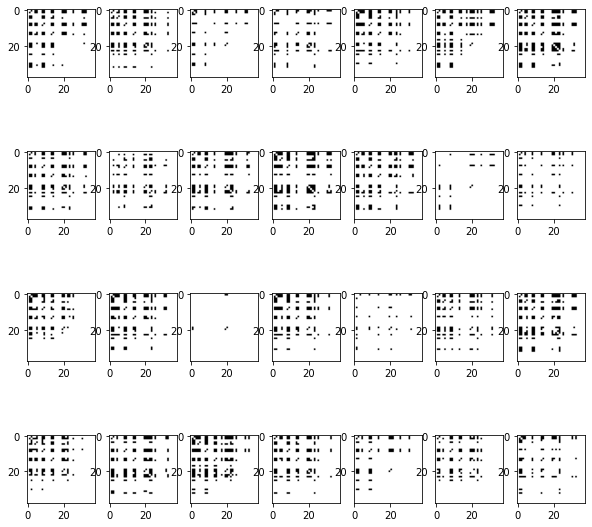

In [26]:
# original adj matrices

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 7, figsize=(10,10))
for i in range(28):
    plt.subplot(4, 7, i+1)
    plt.imshow(ctrl_data.get_adj_m()[i], cmap="Greys")

In [31]:
out_channels = 2
n_node = 38
num_features = n_node

VGAE_Encoder = Encoder(num_features, out_channels)
model = VGAE(VGAE_Encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epochs = 10000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    
    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model.encode(train_data.x, train_data.edge_index)
        loss = model.recon_loss(z, train_data.edge_index)
        loss = loss + (1 /num_features) * model.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    if epoch % 100 ==0:
        print(str(epoch)+str(loss_avg))

0tensor(1.7493, grad_fn=<DivBackward0>)
100tensor(0.9561, grad_fn=<DivBackward0>)
200tensor(0.8056, grad_fn=<DivBackward0>)
300tensor(0.7669, grad_fn=<DivBackward0>)
400tensor(0.7776, grad_fn=<DivBackward0>)
500tensor(0.7616, grad_fn=<DivBackward0>)
600tensor(0.7437, grad_fn=<DivBackward0>)
700tensor(0.7357, grad_fn=<DivBackward0>)
800tensor(0.7421, grad_fn=<DivBackward0>)
900tensor(0.7348, grad_fn=<DivBackward0>)
1000tensor(0.7430, grad_fn=<DivBackward0>)
1100tensor(0.7317, grad_fn=<DivBackward0>)
1200tensor(0.7425, grad_fn=<DivBackward0>)
1300tensor(0.7299, grad_fn=<DivBackward0>)
1400tensor(0.7361, grad_fn=<DivBackward0>)
1500tensor(0.7557, grad_fn=<DivBackward0>)
1600tensor(0.7225, grad_fn=<DivBackward0>)
1700tensor(0.7208, grad_fn=<DivBackward0>)
1800tensor(0.7278, grad_fn=<DivBackward0>)
1900tensor(0.7163, grad_fn=<DivBackward0>)
2000tensor(0.7383, grad_fn=<DivBackward0>)
2100tensor(0.7279, grad_fn=<DivBackward0>)
2200tensor(0.7338, grad_fn=<DivBackward0>)
2300tensor(0.7525, grad

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

1

In [ ]:
valid_loss_total = 0
for valid_data in valid_dataset:
    z = model.encode(valid_data.x, valid_data.edge_index)
    loss = model.recon_loss(z, valid_data.edge_index)
    valid_loss_total += loss
valid_loss_total = valid_loss_total / len(valid_dataset)
valid_loss_total

In [ ]:
valid_loss_total = 0
for i in range(28,32):
    ori_adj_mat = ipf_data.get_adj_m()[i]
    valid_data = ipf_data.graph_dataset()[i]
    z = model.encode(valid_data.x, valid_data.edge_index)
    adj_mat_recon = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat_recon[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()

In [32]:
# os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
# os.getcwd()
PATH = str(out_channels)+'_dim_vgae_model_for_control_data.pth'
# torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '2_dim_vgae_model_for_control_data.pth'

In [39]:
# get mu and logstd 

mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu = model.encode(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))

mu_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))

In [20]:
x = range(100, 1100, 50)
y2 = np.random.uniform(0,1,20)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'p-value of node 23')

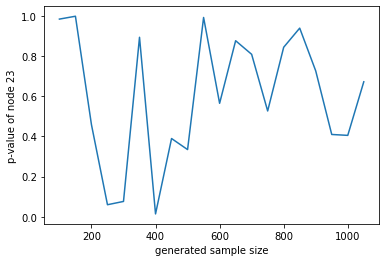

In [22]:
plt.plot(x, y2)
plt.xlabel("generated sample size")
plt.ylabel("p-value of node 23")

In [40]:
# Gaussian distribution for generating mu

import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1    

In [41]:
# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])

In [42]:
def compute_centrality(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

In [43]:
def sample_adj_mat(filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    adj_mat[adj_mat < filter_value] = 0
    adj_mat[adj_mat >= filter_value] = 1
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

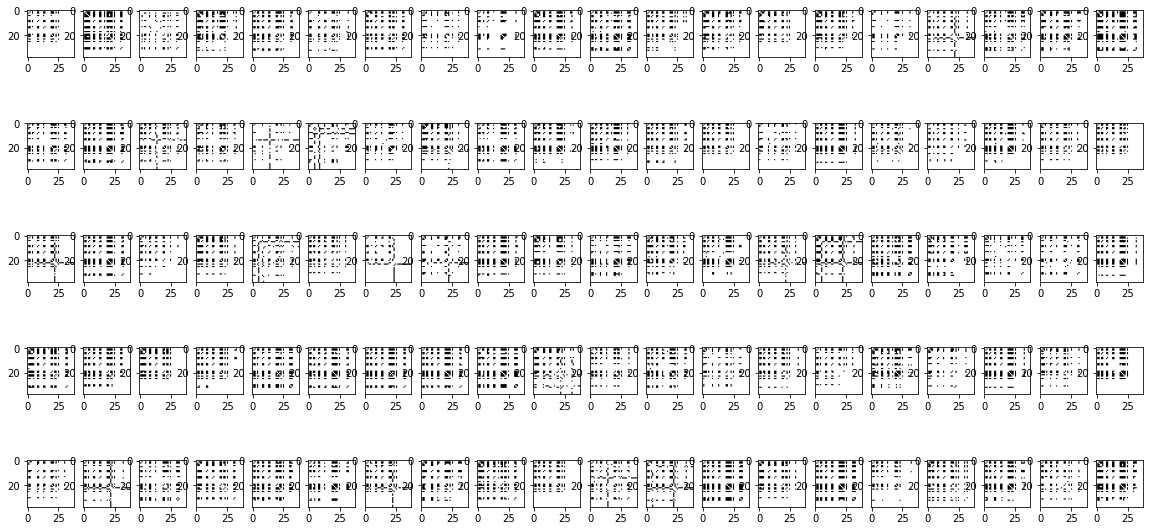

In [44]:
# generate adjacency matrices

generated_from_simu = []
generated_simu_centrality = []

import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 20, figsize=(20,10))
adj_mat_list = []
mu_list = []
for i in range(100):
    plt.subplot(5, 20, i+1)
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.7, filter_eye=True)
    generated_from_simu.append(adj_mat)
    generated_simu_centrality.append(compute_centrality(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
    plt.imshow(adj_mat, cmap="Greys")

In [14]:
simu_adj_list = []
simu_centrality_list = []
for i in range(28):
    adj_mat = ctrl_data.get_adj_m()[i]
    simu_adj_list.append(adj_mat)
    simu_centrality_list.append(compute_centrality(adj_mat))

In [15]:
from scipy import stats
res = stats.ttest_ind(generated_simu_centrality, simu_centrality_list, 
                      equal_var=True, axis=0)
display(res)

Ttest_indResult(statistic=array([63.77325028,  5.93660271,  5.66967337, 23.23260681, 20.10965821,
       12.77497351, 63.77325028, 63.77325028,  5.74983852,  6.91472691,
       63.73306589, 63.77325028, 63.77325028, 13.60330406, 11.37056476,
       63.77325028, 63.77325028, 38.72398446, 63.77325028, 16.93038754,
       17.95583082, 16.94140389, 15.23800634,  8.11449957, 63.77325028,
       26.170012  , 63.77325028, 63.77325028, 63.77325028, 63.77325028,
       20.97634739, 19.30403203, 20.61175234, 63.77325028, 63.73306589,
       63.77325028, 63.77325028, 63.77325028]), pvalue=array([9.15192032e-98, 2.64064638e-08, 9.27379600e-08, 2.23995172e-47,
       3.82073052e-41, 1.73943185e-24, 9.15192032e-98, 9.15192032e-98,
       6.37987738e-08, 2.09277686e-10, 9.88495307e-98, 9.15192032e-98,
       9.15192032e-98, 1.72359305e-26, 4.73830563e-21, 9.15192032e-98,
       9.15192032e-98, 7.91594113e-72, 9.15192032e-98, 2.95810614e-34,
       1.54489005e-36, 2.79382240e-34, 2.27445709e-30, 3.752

In [51]:
not_significant_num = []
for fv in np.linspace(0.6,0.8,21):
    generated_from_simu = []
    generated_simu_centrality = []
    adj_mat_list = []
    mu_list = []
    for i in range(50):
        adj_mat, mu_sample = sample_adj_mat(filter_value=fv, filter_eye=True)
        generated_from_simu.append(adj_mat)
        generated_simu_centrality.append(compute_centrality(adj_mat))
        adj_mat_list.append(adj_mat)
        mu_list.append(mu_sample.detach().numpy())
    simu_adj_list = []
    simu_centrality_list = []
    for i in range(28):
        adj_mat = ctrl_data.get_adj_m()[i]
        simu_adj_list.append(adj_mat)
        simu_centrality_list.append(compute_centrality(adj_mat))
    res = stats.ttest_ind(generated_simu_centrality, simu_centrality_list, 
                      equal_var=True, axis=0)
    not_significant_num.append(np.sum(res.pvalue>0.05/38))

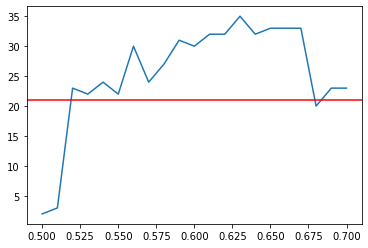

In [66]:
plt.plot(np.linspace(0.5,0.7,21), not_significant_num)
plt.axhline(y=21, color='r', linestyle='-')

In [74]:
generated_from_simu = []
generated_simu_centrality = []
adj_mat_list = []
mu_list = []
for i in range(50):
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.63, filter_eye=True)
    generated_from_simu.append(adj_mat)
    generated_simu_centrality.append(compute_centrality(adj_mat))
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
simu_adj_list = []
simu_centrality_list = []
for i in range(50):
    adj_mat, mu_sample = sample_adj_mat(filter_value=0.63, filter_eye=True)
    simu_adj_list.append(adj_mat)
    simu_centrality_list.append(compute_centrality(adj_mat))
res = stats.ttest_ind(generated_simu_centrality, simu_centrality_list, 
                  equal_var=True, axis=0)
not_significant_num.append(np.sum(res.pvalue>0.05/38))

In [73]:
control_centrality = np.array(generated_simu_centrality)
np.savetxt("ctrl_centr.txt", control_centrality, delimiter=',')

In [75]:
np.around(res.pvalue, decimals=3)

array([1.   , 0.462, 0.757, 0.788, 0.69 , 0.058, 0.562, 0.884, 0.705,
       0.285, 0.518, 1.   , 1.   , 0.782, 0.95 , 0.563, 0.563, 0.795,
       0.884, 0.662, 0.546, 0.985, 0.779, 0.553, 0.46 , 0.677, 0.771,
       0.89 , 0.563, 0.562, 0.182, 0.416, 0.949, 0.793, 0.563, 0.562,
       0.892, 0.793])

In [ ]:
np.round(np.var(simu_centrality_list, axis=0), decimals=3)

In [ ]:
np.around(np.mean(np.vstack(generated_simu_centrality), axis=0),decimals=2)

In [ ]:
np.around(np.mean(np.vstack(simu_centrality_list), axis=0),decimals=2)

In [ ]:
np.around(np.mean(np.vstack(simu_centrality_list), axis=0) - np.mean(np.vstack(generated_simu_centrality), axis=0), decimals=2)